# Imports

In [237]:
import torch
torch.__version__
device = torch.device("mps")
device

device(type='mps')

In [238]:
import nibabel as nib
import pandas as pd
import seaborn as sns

In [239]:
import torch
import nibabel as nib
import numpy as np
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    SpatialPadd,
    DivisiblePadd,
    RandRotated,
    Rand2DElasticd,
    RandGaussianNoised,
    RandZoomd ,
    AdjustContrastd,
    SobelGradientsd
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric, MeanIoU
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, pad_list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import monai.transforms as T
import torch.nn.functional as F
from scipy.ndimage import binary_dilation
print_config()

MONAI version: 1.3.0
Numpy version: 1.26.2
Pytorch version: 2.1.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /Users/<username>/miniconda3/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.11.4
Pillow version: 10.1.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.1
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.1.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.35.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details

# Loading Traning, Validating and Testing Data

In [240]:
# Set the base directory for dataset
base_dir = './Converted Pelvis Nifti Dataset'
#base_dir = 'D:\\OPEN_CAMPUS\\ML_FÜR_MEDIZIN\\Converted Pelvis Nifti Dataset\\Converted Pelvis Nifti Dataset'

# Training data paths
train_img_dir = os.path.join(base_dir, 'train', 'imgs')
train_label_dir = os.path.join(base_dir, 'train', 'targets')


# Validtation of data paths
valid_img_dir = os.path.join(base_dir, 'valid', 'imgs')
valid_label_dir = os.path.join(base_dir, 'valid', 'targets')

# Test data paths
test_img_dir = os.path.join(base_dir, 'test', 'imgs')
test_label_dir = os.path.join(base_dir, 'test', 'targets')


# Load training images and labels
train_images = sorted(glob.glob(os.path.join(train_img_dir, "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(train_label_dir, "*.nii.gz")))

train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

# Load validating images and labels

valid_images = sorted(glob.glob(os.path.join(valid_img_dir, "*.nii.gz")))
valid_labels = sorted(glob.glob(os.path.join(valid_label_dir, "*.nii.gz")))

valid_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(valid_images, valid_labels)]

# Load testing images and labels
test_images = sorted(glob.glob(os.path.join(test_img_dir, "*.nii.gz")))
test_labels = sorted(glob.glob(os.path.join(test_label_dir, "*.nii.gz")))
test_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(test_images, test_labels)]


In [241]:

# indices_to_remove_train = {5, 10, 16, 34, 39, 45, 53, 58,  72, 78, 81, 83, 85, 86, 90, 103, 108, 115, 122, 140, 142, 178, 193, 195, 199, 214,  243, 247, 254, 255, 277, 286, 287, 312, 319}
# train_files = [{"image": image_name, "label": label_name} for i, (image_name, label_name) in enumerate(zip(train_images, train_labels)) if i not in indices_to_remove_train]

# indices_to_remove_valid = {5, 29, 32, 33, 36, 40, 46,  59, 64, 68}
indices_to_remove_valid = {5}
valid_files = [{"image": image_name, "label": label_name} for i, (image_name, label_name) in enumerate(zip(valid_images, valid_labels)) if i not in indices_to_remove_valid]

In [242]:
def analyze_original_image(image_files):
    widths, heights = [], []
    for file in image_files:
        nifti_file = nib.load(file)
        image_data = nifti_file.get_fdata()
        widths.append(image_data.shape[0])
        heights.append(image_data.shape[1])
 
    return widths, heights

# Collect dimensions for training and validation datasets
train_widths, train_heights = analyze_original_image(test_images)
valid_widths, valid_heights = analyze_original_image(valid_images)


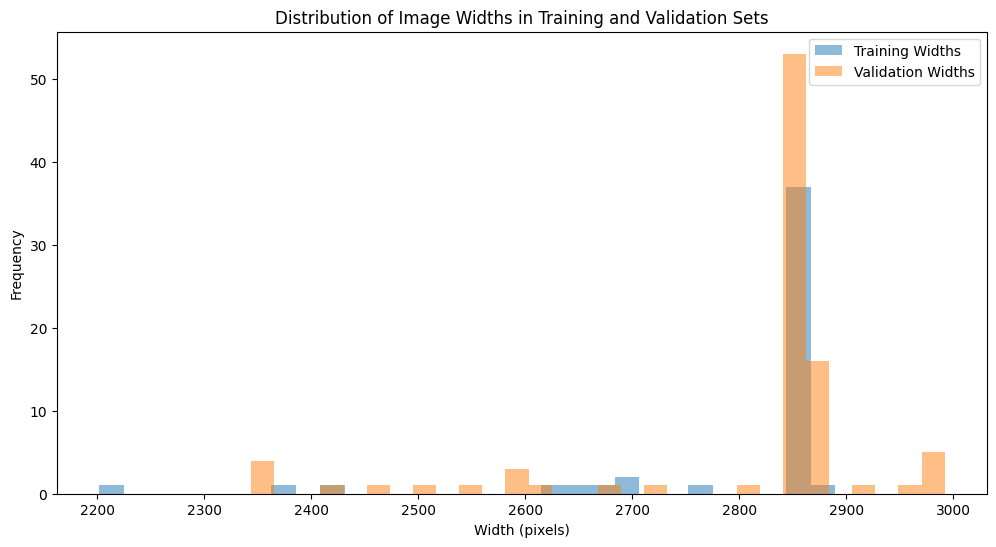

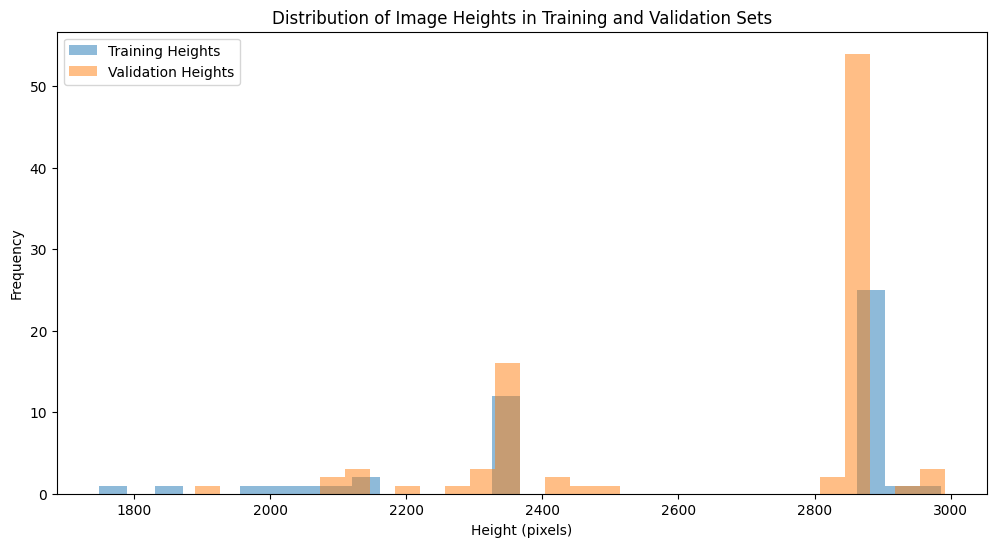

In [243]:
# Histograms for Image Widths
plt.figure(figsize=(12, 6))
plt.hist(train_widths, bins=30, alpha=0.5, label='Training Widths')
plt.hist(valid_widths, bins=30, alpha=0.5, label='Validation Widths')
plt.title('Distribution of Image Widths in Training and Validation Sets')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Histograms for Image Heights
plt.figure(figsize=(12, 6))
plt.hist(train_heights, bins=30, alpha=0.5, label='Training Heights')
plt.hist(valid_heights, bins=30, alpha=0.5, label='Validation Heights')
plt.title('Distribution of Image Heights in Training and Validation Sets')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Checking Loaded Datas

In [244]:
# Print to check if files are loaded
print("Number of training images:", len(train_images))
print("Number of training labels:", len(train_labels))

print("Number of validating images:", len(valid_images))
print("Number of validating labels:", len(valid_labels))

print("Number of testing images:", len(test_images))
print("Number of testing labels:", len(test_labels))

Number of training images: 320
Number of training labels: 320
Number of validating images: 91
Number of validating labels: 91
Number of testing images: 47
Number of testing labels: 47


In [245]:
# Print to check if files are loaded
print("Number of training files:", len(train_files))
print("Number of valid files:", len(valid_files))

Number of training files: 320
Number of valid files: 90


In [246]:
print(train_files[0])
print("----------------")
print(valid_files[0])
print("----------------")
print(test_files[0])
print("----------------")

{'image': './Converted Pelvis Nifti Dataset/train/imgs/HIP_0000.nii.gz', 'label': './Converted Pelvis Nifti Dataset/train/targets/HIP_0000.nii.gz'}
----------------
{'image': './Converted Pelvis Nifti Dataset/valid/imgs/HIP_0320.nii.gz', 'label': './Converted Pelvis Nifti Dataset/valid/targets/HIP_0320.nii.gz'}
----------------
{'image': './Converted Pelvis Nifti Dataset/test/imgs/HIP_0411.nii.gz', 'label': './Converted Pelvis Nifti Dataset/test/targets/HIP_0411.nii.gz'}
----------------


In [247]:
# Extracting the file path from data structure
image_file_train = train_files[0]['image']
image_file_label = train_files[0]['label']
# Load the NIfTI file
nifti_file_train = nib.load(image_file_train)
nifti_file_label = nib.load(image_file_label)
# Get the image data
image_sample_train = nifti_file_train.get_fdata()
image_sample_label = nifti_file_label.get_fdata()
# Print the dimensions of the image
print("Dimensions of train images:", image_sample_train.shape)
print("Dimensions of label images:", image_sample_label.shape)

Dimensions of train images: (2860, 2874)
Dimensions of label images: (2860, 2874)


In [248]:
print("Data type of train images:", image_sample_train.dtype)
print("Number of dimensions in single train image:", image_sample_train.ndim)

Data type of train images: float64
Number of dimensions in single train image: 2


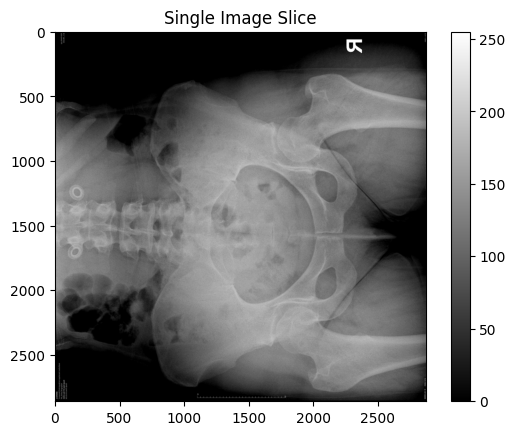

In [249]:
plt.imshow(image_sample_train, cmap='gray')  # 'gray' colormap is often used for medical images
plt.colorbar()  # Adds a color bar to interpret intensity values
plt.title("Single Image Slice")
plt.show()


In [250]:
print(image_sample_train[2000][-500:])

[ 98.  95.  98.  98.  98.  96.  95.  96.  99. 102.  98. 101. 104. 104.
 102. 101. 103. 105. 109. 107. 104.  99.  95.  94.  96.  98.  95. 101.
 107. 109. 107. 106. 108. 111. 110. 111. 111. 109. 108. 109. 111. 114.
 105. 106. 104. 100. 100. 104. 106. 105. 108. 107. 103. 100. 103. 107.
 107. 104. 104. 102. 102. 105. 108. 108. 102.  97. 104. 106. 104. 101.
  99.  99.  98.  95. 106. 107. 107. 105. 103. 100. 100. 100. 102. 102.
 102. 102. 103. 104. 105. 105. 112. 110. 109. 110. 111. 111. 109. 108.
  98. 100. 102. 101.  99.  99. 101. 103. 103. 102. 101. 103. 106. 109.
 108. 106. 103. 100. 101. 105. 106. 102.  97.  94.  95.  96.  97. 100.
 102. 103. 102. 101. 110. 110. 109. 106. 102.  99.  97.  96. 104. 111.
 118. 117. 111. 107. 107. 109. 107. 102.  99. 103. 108. 107. 105. 104.
 107. 109. 108. 105. 105. 107. 108. 106. 107. 105. 101.  99.  99. 100.
 100. 100. 102. 100.  99.  99. 101. 103. 103. 102. 104. 103. 101. 101.
 101. 100.  98.  97.  95.  99. 101. 106. 112. 106.  98.  99. 100.  98.
  95. 

In [251]:
set_determinism(seed=0)

# Custom Transformer

In [252]:
class ReplaceValuesNotInList(T.MapTransform):
    def __init__(self, keys, allowed_values, replacement_value):
        super().__init__(keys)
        self.allowed_values = set(allowed_values)
        self.replacement_value = replacement_value

    def __call__(self, data):
        for key in self.keys:
            if key in data:
                data[key] = np.where(np.isin(data[key], list(self.allowed_values)),
                                     data[key],
                                     self.replacement_value)
        return data


class PadToMaxSize(T.MapTransform):
    def __init__(self, keys, mode='constant', constant_values=0):
        super().__init__(keys)
        # self.keys = keys
        self.mode = mode
        self.constant_values = constant_values

    def __call__(self, data):
        # Calculate the maximum spatial size for each dimension
        for key in self.keys:
            if key in data:
                print(key, data[key].shape)

        max_sizes = np.max([np.array(data[key].shape) for key in self.keys], axis=0)
        print('max size', max_sizes)
        # Calculate the padding amounts for each dimension
        padding = {}
        for key in self.keys:
            padding[key] = [(0, max_size - data[key].shape[i]) for i, max_size in enumerate(max_sizes)]
        print('padding', padding)

        # Pad each image in the batch
        for key in self.keys:
            if key in data:
                data[key] = np.pad(data[key], padding[key], mode=self.mode, constant_values=self.constant_values)

        return data

In [253]:
class HighlightBoneBorders(T.MapTransform):
    def __init__(self, keys, threshold, color_map):
        """
        Custom transform to highlight bone borders based on intensity.
        :param keys: Keys of the images to be transformed.
        :param threshold: Intensity threshold to identify bone borders.
        :param color_map: Function that applies a color transformation based on intensity.
        """
        super().__init__(keys)
        self.threshold = threshold
        self.color_map = color_map

    def __call__(self, data):
        for key in self.keys:
            if key in data:
                image = data[key]
                # Apply the color map transformation to pixels above the threshold
                mask = image > self.threshold
                data[key] = np.where(mask, self.color_map(image), image)
        return data

# Example of a color_map function
def bone_color_map(intensity):
    """
    Apply a color transformation to the intensity.
    :param intensity: Pixel intensity.
    :return: Transformed intensity.
    """
    # Example transformation, modify as needed
    return intensity * .4  # Increase intensity by 20%


In [254]:
class SelectiveIntensificationTransform(T.MapTransform):
    def __init__(self, keys, threshold, intensification_factor):
        super().__init__(keys)
        self.threshold = threshold
        self.intensification_factor = intensification_factor

    def __call__(self, data):
        for key in self.keys:
            if key in data:
                # Convert to NumPy array for processing
                image = data[key].cpu().numpy()

                # Apply the selective intensification
                mask = image > self.threshold
                intensified_pixels = image[mask] * self.intensification_factor
                intensified_pixels = np.clip(intensified_pixels, 0, 1)  # Assuming image is normalized
                image[mask] = intensified_pixels

                # Convert back to PyTorch tensor
                data[key] = torch.tensor(image, dtype=torch.float32)

        return data

In [255]:
class ConditionalRandCropByPosNegLabel(T.MapTransform):
    def __init__(self, keys, label_key, spatial_size, pos, neg, num_samples, image_key, image_threshold, size_threshold):
        super().__init__(keys)
        self.label_key = label_key
        self.spatial_size = spatial_size
        self.pos = pos
        self.neg = neg
        self.num_samples = num_samples
        self.image_key = image_key
        self.image_threshold = image_threshold
        self.size_threshold = size_threshold

    def __call__(self, data):
        for key in self.keys:
            if key in data:
                # Check if cropping is needed based on size threshold
                if data[key].shape[1] > self.size_threshold[0] or data[key].shape[2] > self.size_threshold[1]:
                    cropper = RandCropByPosNegLabeld(
                        keys=[self.image_key, self.label_key],
                        label_key=self.label_key,
                        spatial_size=self.spatial_size,
                        pos=self.pos,
                        neg=self.neg,
                        num_samples=self.num_samples,
                        image_key=self.image_key,
                        image_threshold=self.image_threshold,
                    )
                    data = cropper(data)
        return data

# Pre-processing Traning and Validating Images for Training

### Compose :
        Provides ability to chain a series of callables in a sequential manner.
        Each transform in sequence must take single argument and return single value.

#### LoadImaged:
        Loads image-data and metadata. 
        keys -> Keys of Corresponding items to be transformed.
#### EnsureChannelFirstd:
        Channel -> Kind of features of an image : ( Gray scyle -> 1, Colour -> 3 (RGB)
        A single image has, colour, width, height ->
        Channel first -> (Colour_feature, width ,height), Channel last -> (width, height, colour_feature)
        Adds/Adjust channel_dimention of input data to ensure channel first shape.
        keys -> Keys of corresponding items to be transformed.
#### ScaleIntensityRanged:
        Apply intensity scaling to from [a_min, a_max] to [b_min, b_max]
        Intensity -> Grey level of pixel value. 0 -> Black, 255 -> White
        Intensity Scaling -> Changing range of pixel intesity values of original image by mapping to new range.
        Can change the brightness, darkness or even inverting the colour.
        a_min & a_max -> Define original range of intensity values in image. Only values within this range are considered 
                         for scaling.
        b_min & b_max -> Traget range to which original intensities will be scaled.
        
        i.e. Values below a_min will be black, and value above a_max will be complete white.
        clip == True -> Values mapped outside the range will be adjusted to the limit.
###  Need to adjust in such a way that only the relevant bone section can be visible. ??
    
#### CropForgroundd:
        Crop the relevant parts of image.
        i.e. The image is cropped only the part that is passed as a source_key. The image section 
        determined is determined via bounding box.
#### Orientationd:
        Change the input image orientation
        (L, R) -> Left, Right
        (P, A) -> Posterior, Anterior
        (I, S) -> Inferior, Superior
#### Spacingd:
        Resample / (Changes) the resolution/(spatial dimentions) of the image. Done via increasing or decreasing 
        the image.
        PixeDim -> Decreases the size of pixel by number of times mentioned in pixdim. Each number present in it 
        decreases the corresponding pixel of that axes. 
        mode -> bilinear ?? nearest ??
#### RandCropByPosNegLabel:
        Crop random fixed size with center being foregraound or based on Pos Neg Ration.
        Returns list of arrays for all cropped images. i.e. Returs list of images.
        If expected spatial size is larger than input image -> No crop is being done. 
        If ROI is partly out of image, it will adjust and ensure valid crop ROI
        spatial_size -> How many pixels are to be considered in final image that contains maximum labels present in the
        image.
        num_samples -> Number of cropped images required from a picture
        pos & reg -> Used to calcualte probability to pick foreground as center rather than background voxel

a_min = 0 --> Needed for target level 2
a_max = 255 ---> Needed for target level 5

In [418]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="LA"),#"RAS"),
        ReplaceValuesNotInList(keys=['label'], allowed_values=[0,2, 5, 6], replacement_value=0),

        SpatialPadd(keys=["image", "label"], spatial_size=(2991, 2992)),
         ConditionalRandCropByPosNegLabel(
            keys=["image", "label"],
            label_key="label",
        #    spatial_size=(1856, 1856),
            spatial_size=(2352, 1792),          # for all, space 5, 5
        #    spatial_size=(1900, 1500),          # for all, space 5, 5
             
        #    spatial_size=(2991, 2992),          # for all, space 5, 5
            
            
            pos=1,
            neg=0.2,
            num_samples=4,
            image_key="image",
            image_threshold=0,
            size_threshold=(200, 200)  # Example threshold
        ),
   #     Spacingd(keys=["image", "label"], pixdim=(6, 6), mode=("bilinear", "nearest")),
        Spacingd(keys=["image", "label"], pixdim=(5, 5), mode=("bilinear", "nearest")),

        DivisiblePadd(keys=["image", "label"], k=16, method="symmetric"),

        RandRotated(keys=["image", "label"],range_x=np.pi, prob=0.6, keep_size=True, padding_mode="zeros",  mode = ["bilinear", "nearest"]),
       Rand2DElasticd(keys=["image", "label"],prob=0.3, spacing=(30, 30), magnitude_range=(0.1, 0.3),  padding_mode="zeros", mode = ["bilinear", "nearest"]), #woble de
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=255,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
       RandGaussianNoised(
        keys=['image'],
            prob=0.1,
        mean=0.0,
            std=0.03
        )

    ]
)


val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="LA"),#"RAS"),
        ReplaceValuesNotInList(keys=['label'], allowed_values=[0, 2, 5, 6], replacement_value=0),

        SpatialPadd(keys=["image", "label"], spatial_size=(2991, 2992)),
        Spacingd(keys=["image", "label"], pixdim=(6, 6), mode=("bilinear", "nearest")),

        DivisiblePadd(keys=["image", "label"], k=16, method="symmetric"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=255,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),

    ]
)

Image shape: torch.Size([480, 368]), Label shape: torch.Size([480, 368])
Unique label values in the image: [0. 2. 5. 6.]
Number of unique labels in the image: 4
Unique label values in the image: [0. 2. 5. 6.]
Counts of each label value: [170893   4885    332    530]
Label 0.0: 170893 
Label 2.0: 4885 
Label 5.0: 332 
Label 6.0: 530 


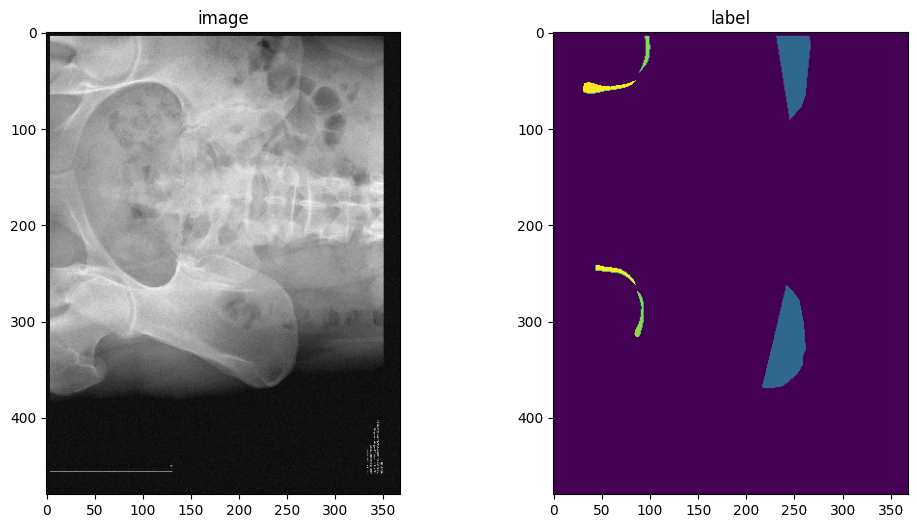

In [420]:
def get_image_at_index(data_loader, index):
    for i, batch in enumerate(data_loader):
        if i == index:
            # Extract image and label from the batch
            image, label = batch["image"][0][0], batch["label"][0][0]
            return image, label
    raise IndexError("Index out of range")

# Create the DataLoader
check_ds = Dataset(data=valid_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)

# Get the image and label at a specific index
index = 2
image, label = get_image_at_index(check_loader, index)
print(f"Image shape: {image.shape}, Label shape: {label.shape}")

# List all unique label values in the label
unique_label_values = np.unique(label)
print("Unique label values in the image:", unique_label_values)

# Count the number of unique labels
num_unique_labels = len(unique_label_values)
print("Number of unique labels in the image:", num_unique_labels)

# List all unique label values and their counts in the label
unique_label_values, counts = np.unique(label, return_counts=True)
print("Unique label values in the image:", unique_label_values)
print("Counts of each label value:", counts)

# Print the count for each unique label
for label_value, count in zip(unique_label_values, counts):
    print(f"Label {label_value}: {count} ")


# plot the images
plt.figure("check", (12, 6))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image, cmap="gray")  # adjusted for 2D tensor

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label)  # adjusted for 2D tensor

plt.show()

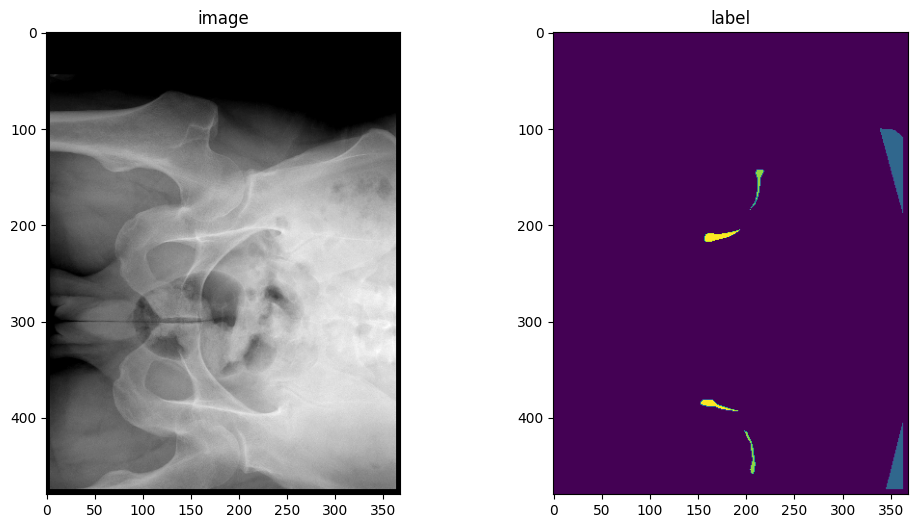

Image shape: torch.Size([480, 368]), Label shape: torch.Size([480, 368])
Unique label values in the image: [0. 2. 5. 6.]
Counts of each label value: [174385   1667    242    346]
0


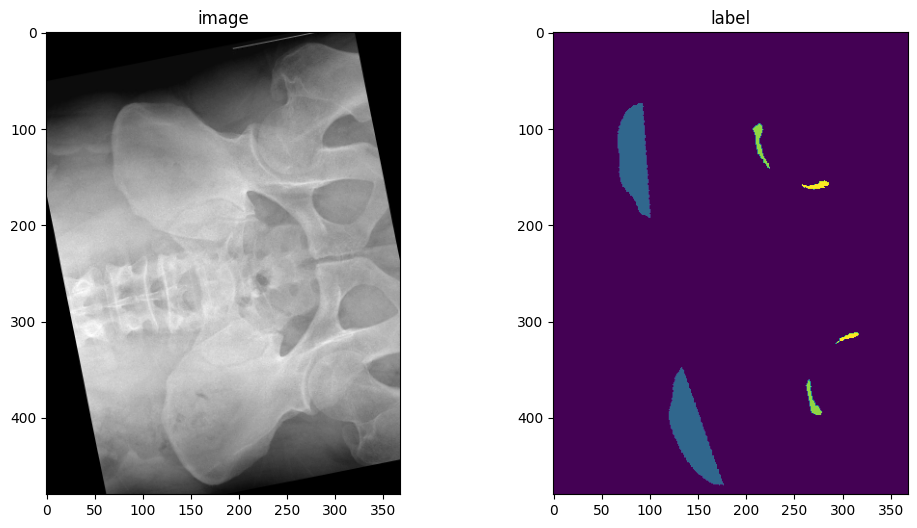

Image shape: torch.Size([480, 368]), Label shape: torch.Size([480, 368])
Unique label values in the image: [0. 2. 5. 6.]
Counts of each label value: [170310   5672    444    214]
1


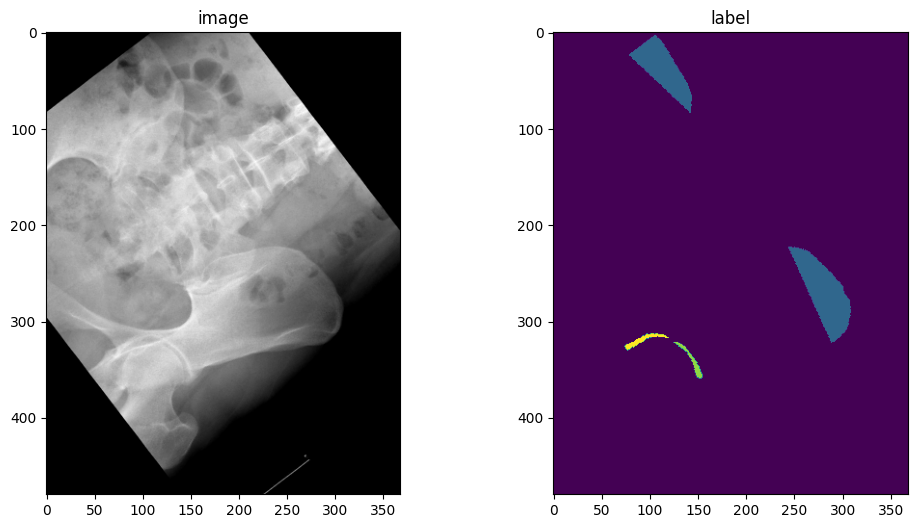

Image shape: torch.Size([480, 368]), Label shape: torch.Size([480, 368])
Unique label values in the image: [0. 2. 5. 6.]
Counts of each label value: [171367   4881    188    204]
2


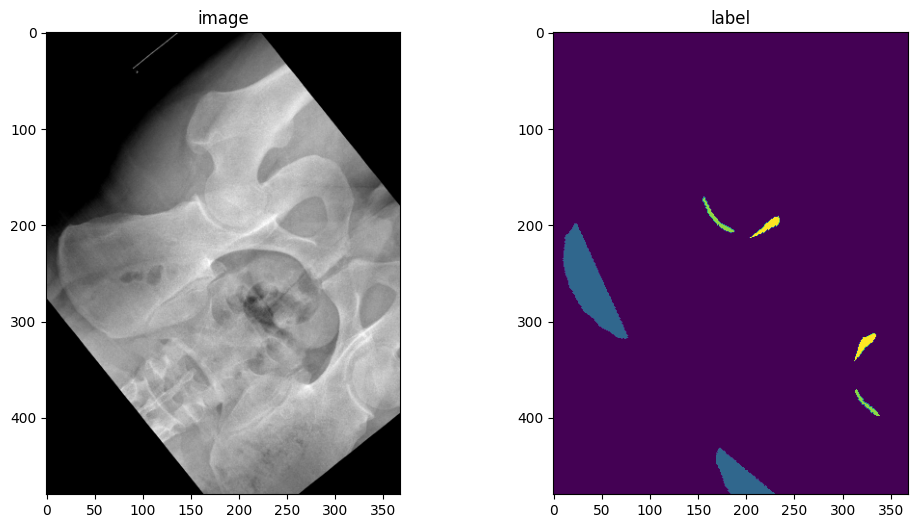

Image shape: torch.Size([480, 368]), Label shape: torch.Size([480, 368])
Unique label values in the image: [0. 2. 5. 6.]
Counts of each label value: [171326   4590    320    404]
3


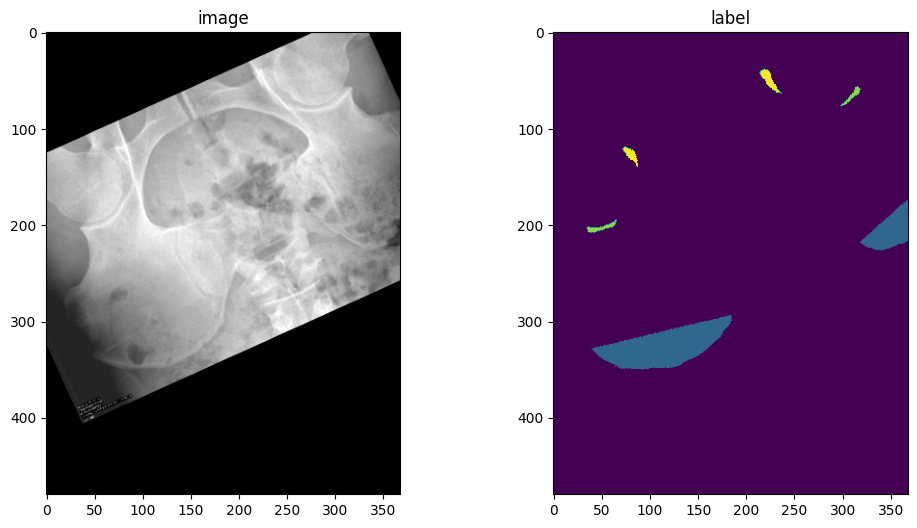

Image shape: torch.Size([480, 368]), Label shape: torch.Size([480, 368])
Unique label values in the image: [0. 2. 5. 6.]
Counts of each label value: [170645   5434    234    327]
4


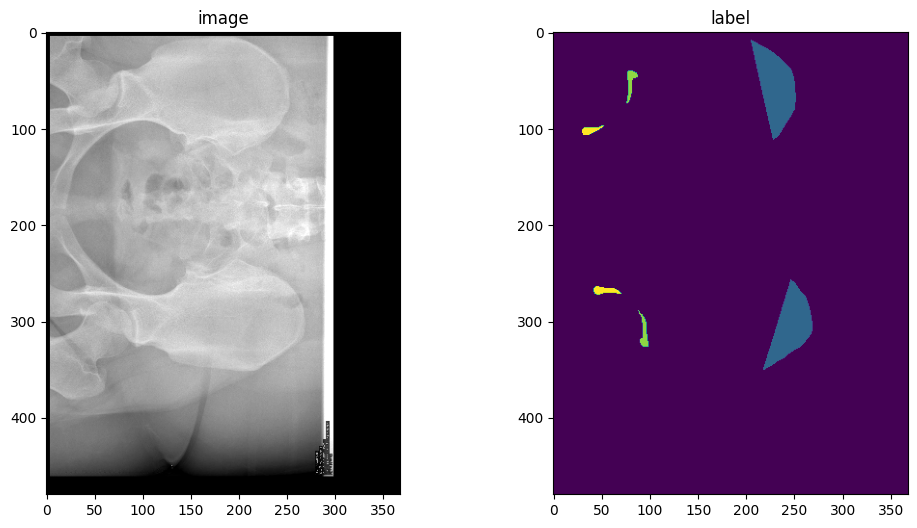

Image shape: torch.Size([480, 368]), Label shape: torch.Size([480, 368])
Unique label values in the image: [0. 2. 5. 6.]
Counts of each label value: [171132   4883    347    278]
5


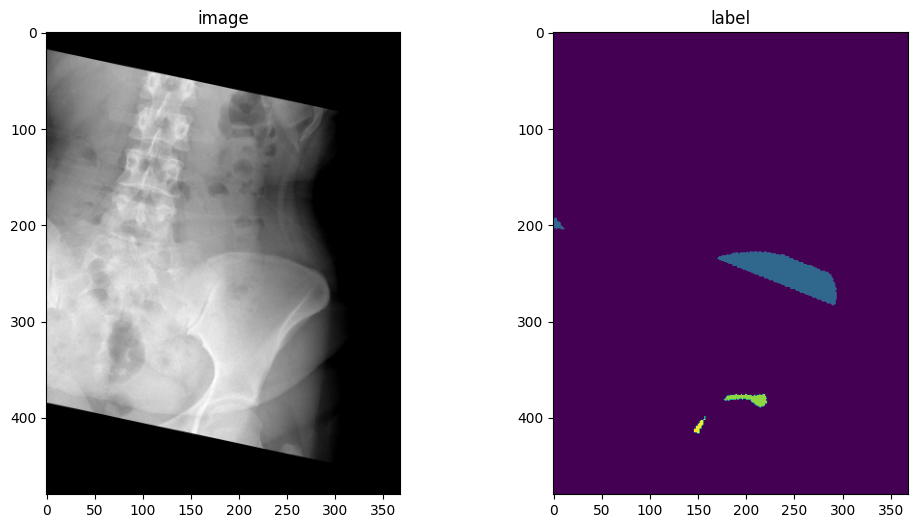

Image shape: torch.Size([480, 368]), Label shape: torch.Size([480, 368])
Unique label values in the image: [0. 2. 5. 6.]
Counts of each label value: [173142   3117    304     77]
6


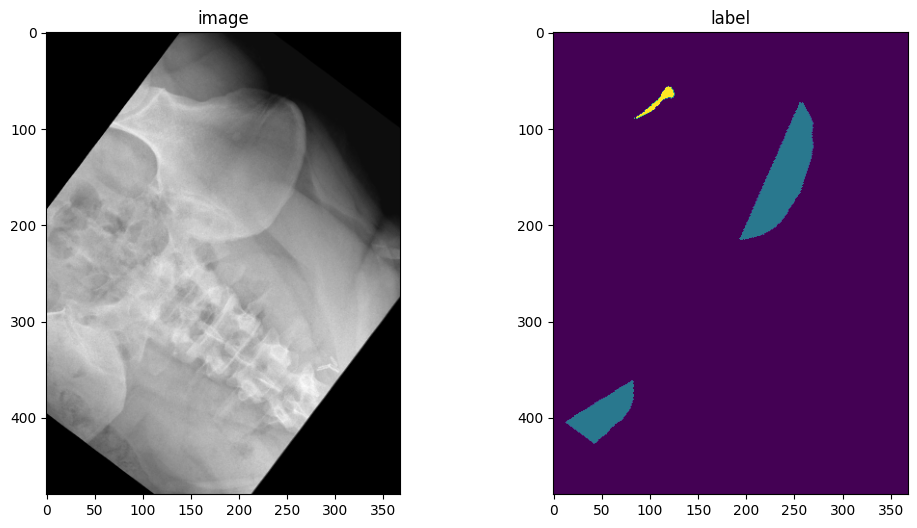

Image shape: torch.Size([480, 368]), Label shape: torch.Size([480, 368])
Unique label values in the image: [0. 2. 5.]
Counts of each label value: [169854   6518    268]
7


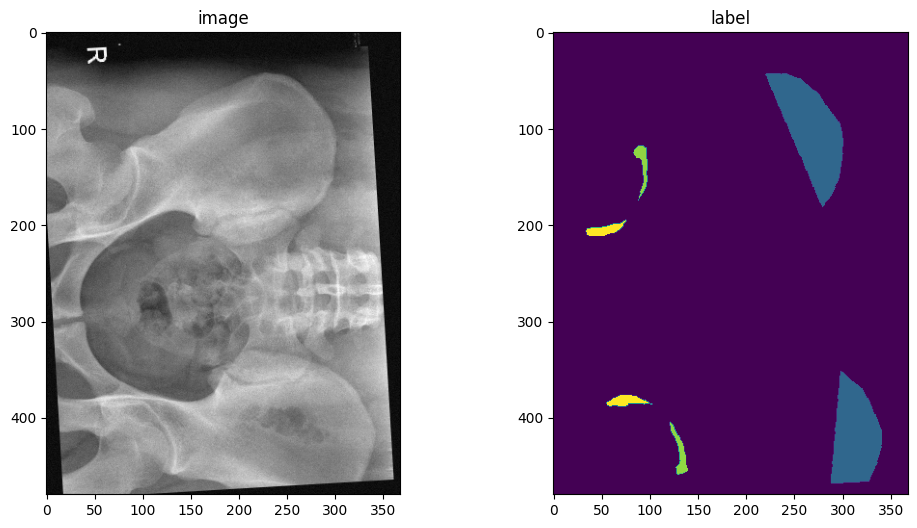

Image shape: torch.Size([480, 368]), Label shape: torch.Size([480, 368])
Unique label values in the image: [0. 2. 5. 6.]
Counts of each label value: [165511   9788    674    667]
8


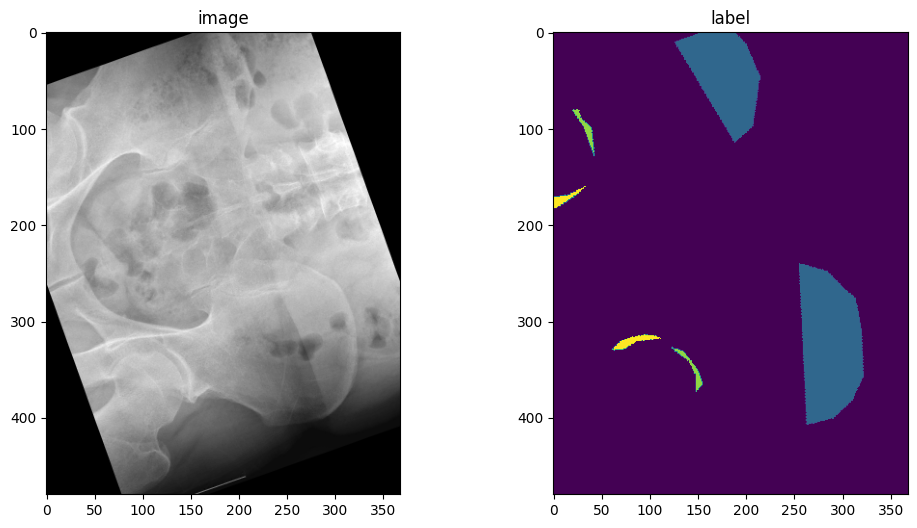

Image shape: torch.Size([480, 368]), Label shape: torch.Size([480, 368])
Unique label values in the image: [0. 2. 5. 6.]
Counts of each label value: [161397  14273    460    510]
9


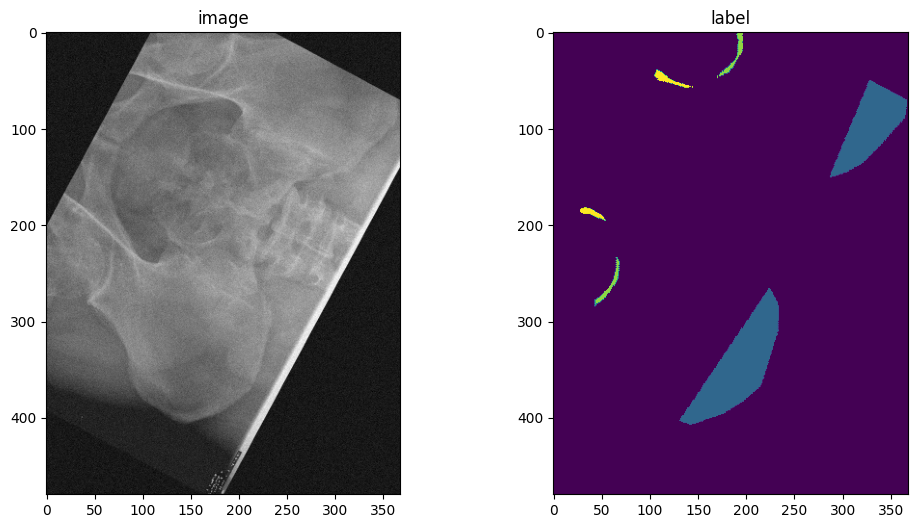

Image shape: torch.Size([480, 368]), Label shape: torch.Size([480, 368])
Unique label values in the image: [0. 2. 5. 6.]
Counts of each label value: [166543   9324    440    333]
10


In [421]:
def plot_images_in_range(data_loader, start_index, end_index):
    count = 0;
    for index in range(start_index, end_index + 1):
        try:
            image, label = get_image_at_index(data_loader, index)

            unique_label_values, counts = np.unique(label, return_counts=True)

            plt.figure(f"Index: {index}", (12, 6))

            plt.subplot(1, 2, 1)
            plt.title("image")
            plt.imshow(image, cmap="gray")  # assuming 2D tensor

            plt.subplot(1, 2, 2)
            plt.title("label")
            plt.imshow(label)  # assuming 2D tensor

            plt.show()

            print(f"Image shape: {image.shape}, Label shape: {label.shape}")
            print("Unique label values in the image:", unique_label_values)
            print("Counts of each label value:", counts)

            print(count)
            count = count + 1;
  #          for label_value, count in zip(unique_label_values, counts):
   #             print(f"Label {label_value}: {count} ")
        except IndexError:
            print(f"Index {index} is out of range")
            break

start_index = 0
end_index = 10
plot_images_in_range(check_loader, start_index, end_index)

In [422]:
# Get the image and label at a specific index
index = 3
image, label = get_image_at_index(check_loader, index)
print(f"Image shape: {image.shape}, Label shape: {label.shape}")

# List all unique label values in the label
unique_label_values = np.unique(label)
print("Unique label values in the image:", unique_label_values)

# Count the number of unique labels
num_unique_labels = len(unique_label_values)
print("Number of unique labels in the image:", num_unique_labels)

Image shape: torch.Size([480, 368]), Label shape: torch.Size([480, 368])
Unique label values in the image: [0. 2. 5. 6.]
Number of unique labels in the image: 4


In [423]:
# List all unique label values and their counts in the label
unique_label_values, counts = np.unique(label, return_counts=True)
print("Unique label values in the image:", unique_label_values)
print("Counts of each label value:", counts)

# Print the count for each unique label
for label_value, count in zip(unique_label_values, counts):
    print(f"Label {label_value}: {count} ")

Unique label values in the image: [0. 2. 5. 6.]
Counts of each label value: [169511   6412    306    411]
Label 0.0: 169511 
Label 2.0: 6412 
Label 5.0: 306 
Label 6.0: 411 


In [163]:
# Initialize dictionaries to count label occurrences and track image counts
label_sums = {}
image_counts = {}

count = 0
for batch in check_loader:
    count += 1
    label_in_batch = batch["label"][0][0]
    unique, counts = np.unique(label_in_batch, return_counts=True)
    for u, c in zip(unique, counts):
        if u != 0:  # Skip label 0
            label_sums[u] = label_sums.get(u, 0) + c
            image_counts[u] = image_counts.get(u, 0) + 1

# Calculate averages
label_averages = {label: label_sums[label] / image_counts[label] for label in label_sums}

# Convert averages to lists for plotting
labels, averages = zip(*label_averages.items())

# Plotting
plt.bar(labels, averages)
plt.xlabel('Label Values')
plt.ylabel('Average Count per Image')
plt.title('Average Distribution of Label Values in Images')
# Adding the text on each bar
for i in range(len(labels)):
    plt.text(labels[i], averages[i], f'{averages[i]:.2f}', ha='center', va='bottom')

plt.show()

KeyboardInterrupt: 

In [ ]:
def analyze_image_dimensions(check_loader):
    train_widths, train_heights = [], []
    for batch in check_loader:
        image_batch = batch["image"][0][0]
        train_widths.append(image_batch.shape[0])
        train_heights.append(image_batch.shape[1])
 
    return train_widths, train_heights

# Collect dimensions for training and validation datasets
train_widths, train_heights = analyze_image_dimensions(check_loader)


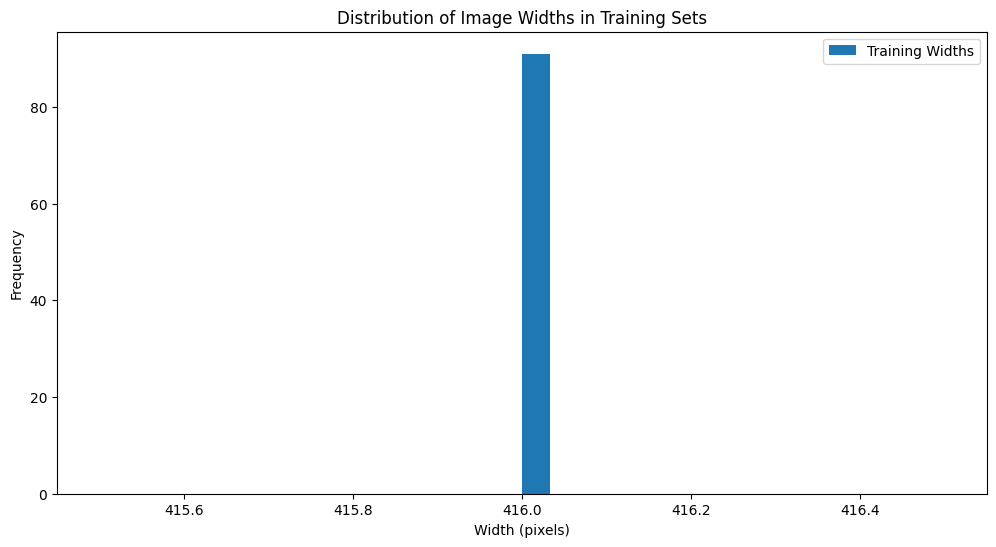

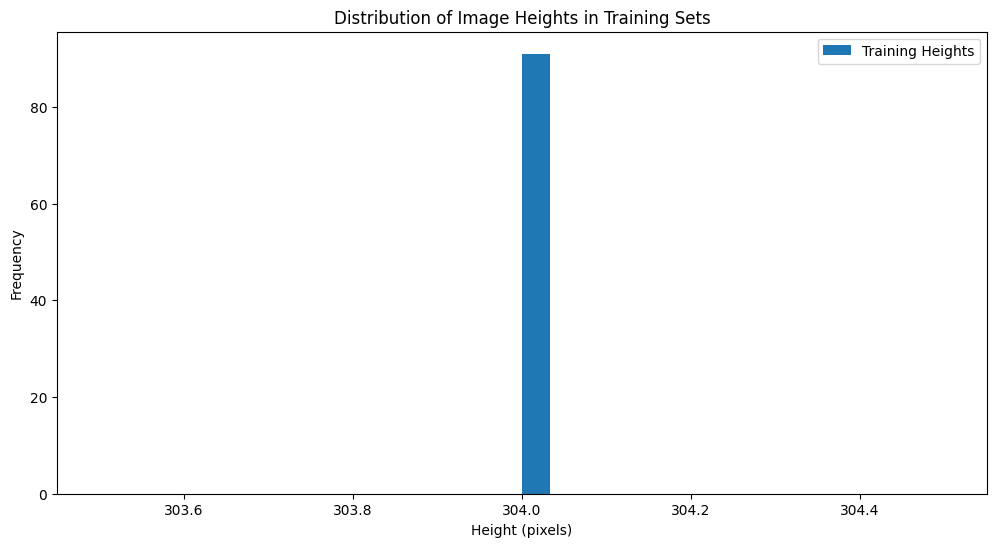

In [44]:
# Histograms for Image Widths
plt.figure(figsize=(12, 6))
plt.hist(train_widths, bins=30, alpha=1, label='Training Widths')
plt.title('Distribution of Image Widths in Training Sets')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Histograms for Image Heights
plt.figure(figsize=(12, 6))
plt.hist(train_heights, bins=30, alpha=1, label='Training Heights')
plt.title('Distribution of Image Heights in Training Sets')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [396]:
print("Dimensions of train images:", image.shape)
print("Dimensions of label images:", image.shape)
print("Data type of train images:", image.dtype)
print("Number of dimensions in single train image:", image.ndim)

Dimensions of train images: torch.Size([352, 272])
Dimensions of label images: torch.Size([352, 272])
Data type of train images: torch.float32
Number of dimensions in single train image: 2


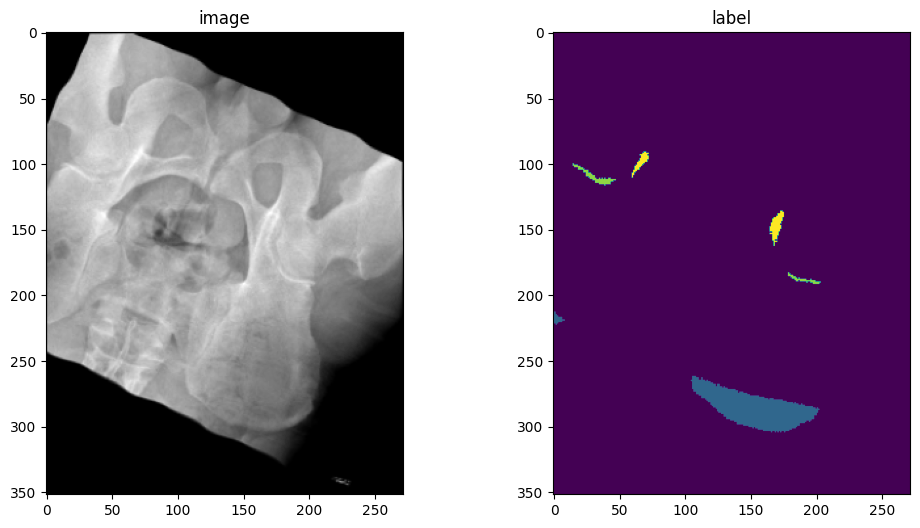

In [397]:
# plot the images
plt.figure("check", (12, 6))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image, cmap="gray")  # adjusted for 2D tensor

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label)  # adjusted for 2D tensor

plt.show()

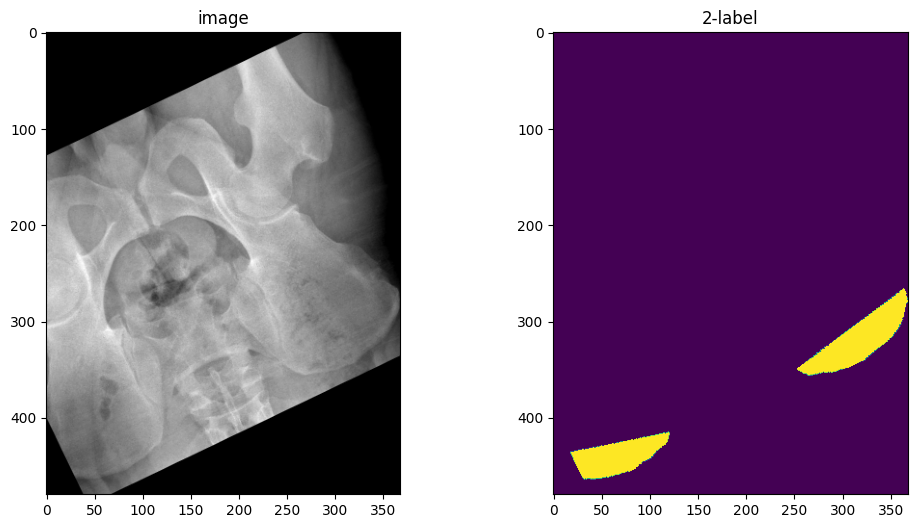

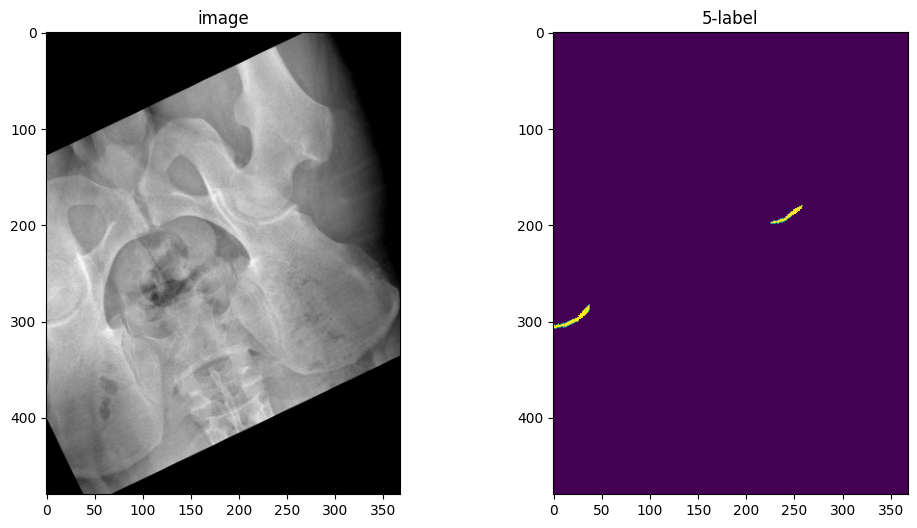

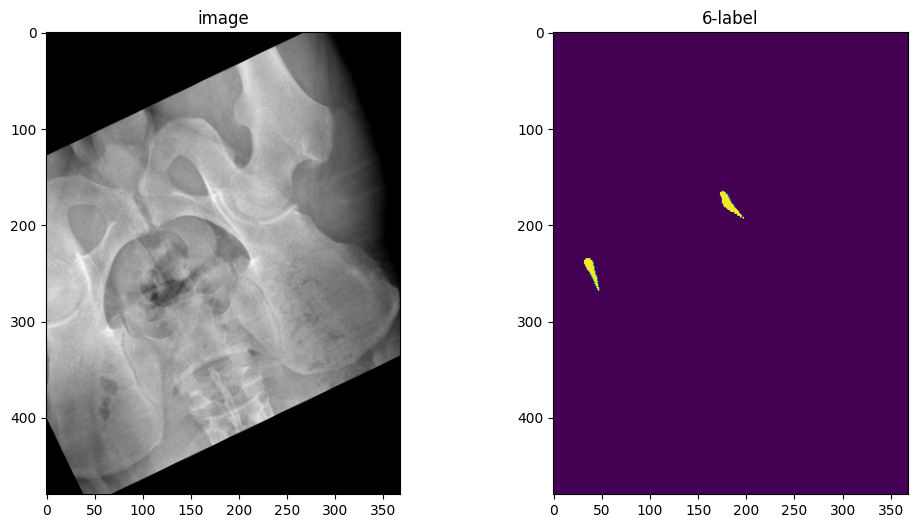

In [441]:
for i in range(1, 7):
    if i in (1, 3, 4):
        continuee
    target_label_value = i
    
    # Isolate the target label in the label
    target_label_only = np.where(label == target_label_value, label, 0)
    
    # plot the images
    plt.figure("check", (12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap="gray")  # adjusted for 2D tensor
    
    plt.subplot(1, 2, 2)
    plt.title(f"{i}-label")
    plt.imshow(target_label_only)  # adjusted for 2D tensor with only the target label
    
    plt.show()

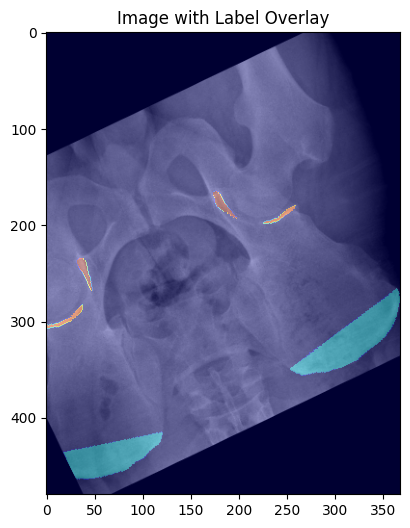

In [424]:
# Plotting image with label overlay
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.imshow(label, cmap='jet', alpha=0.4)
plt.title('Image with Label Overlay')
plt.show()


In [425]:
train_ds = CacheDataset(data = train_files, transform = train_transforms, cache_rate = 1.0, num_workers = 8)
valid_ds = CacheDataset(data = valid_files, transform = val_transforms, cache_rate = 1.0, num_workers = 8)

Loading dataset: 100%|████████████████████████████████████████████████████████████████████| 90/90 [00:05<00:00, 15.39it/s]


In [426]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
validate_loader = DataLoader(valid_ds, batch_size=4)

In [427]:
print("Train Loader Batch Size:", train_loader.batch_size)
print("Validate Loader Batch Size:", validate_loader.batch_size)

Train Loader Batch Size: 8
Validate Loader Batch Size: 4


#### U-Net Model:
        spatial_dims -> spatial dimention for input data
        in_channel -> Number of channel for input data
        out_channel -> Number of output channel. This should align with number of clases or types of segmentation that is 
                       aim to achieve.
        channels (1, 2, 3) ->Tuple defining number of channel at each level  of U-New. It contorls model width and 
                             capacity.
        strides (2, 2, 2) -> Control the downsampling factor at each level. 2 halves the spatial dimensions at each level.
        num_res_units -> number of residual units at each level. helps in addressing vanishing gradient problem.
        norm = Norm.BATCH-> Selection of normalization. 
        
#### Loss Function:
        Dice Loss -> Loss function in image segmentation. Useful when dealing with imbalanced datasets where one class is
                     less represented than other
        to_onehot_y -> target should be one-hot encoded format. i.e. representing the ouptu as multidimensional vector 
                       where each dimension represent a particular class.
        softmax -> Softmax function is requried to calculate the probablity distribuition in the one-hot encoded format.
        
#### Adam Optimizer:
        model.parameters() -> Gets all the trainale parameters of the model (i.e. trainable weight and biases)
        1e-4 -> Learning rate of neural network.
        
#### DiceMetric:
        Evaluating performance of a model based on Dice coefficient -> measurement based on overlap between two samples.
        incude_background -> Include  background class in dice score calculation or not ?
        reduction -> ??

In [428]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=7,
    channels=(16, 32, 64, 128, 256),
#    channels=( 32, 64, 128, 256, 512),
    
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
dice_metric = DiceMetric(include_background=False, reduction="mean")
# Add a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5, verbose=True)

In [429]:
root_dir = '.'

In [430]:
print("Model Output Channels:", model.out_channels) 

Model Output Channels: 7


In [431]:
max_epochs = 500

val_interval = 3 # interval at which validation is to be performed

best_metric = -1 # best metric value determined during whole training process.

best_metric_epoch = -1  # epoch at which best metric was achieved

epoch_loss_values = []  # list to save loss value of each eopch

metric_values = []   # list to save dice-score value for each validation
         
metric_pro_class_values = []

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=7)]) # converts probablites predictions into 
                                                            #    discretevalue of highest probablity value

post_label = Compose([AsDiscrete(to_onehot=7)]) # 

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()                           # model training as artictured above
    epoch_loss = 0                          # initializing loss for current epoch
    step = 0
    for batch_data in train_loader:         # iterating over each batch in traning_loader
        
        print(f"Current step: {step}")
        step += 1
        inputs, labels = (      # extract input and labels from batch data
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )        
        
 #       Model forward pass and Loss computation: 
        optimizer.zero_grad()    # Resets gradients of model parameters before forward pass
        outputs = model(inputs)  # perform feed-forward with padded inputs
        

        
        loss = loss_function(outputs, labels) # computes loss between model outputs and labels
        loss.backward()                       # backwardpropagation of loss for calculating gradients
        
        optimizer.step()                      # updates model parametes based on calculated gradients
        epoch_loss += loss.item()             # total soss for current epoch
        
        # print the training loss for current batch
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        
        
    epoch_loss /= step             # Average loss for epoch
    epoch_loss_values.append(epoch_loss)         # Save average loss in list for epoch
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # if the epoch is even, then perform validation
    if (epoch + 1) % val_interval == 0:
        model.eval()                              # set model to evaluation mode (dropout, batch normlization...)
        with torch.no_grad():                     # disable dradient calculations
            for val_data in validate_loader:      # iterate in each batch in validation data loader
                val_inputs, val_labels = (        # extract input and labels for validation
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (480, 368)            # parameter for sliding window inference
                sw_batch_size = 4                
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model) # perform inference in validation
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]   # post-process outputs
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]   # post-process labels
                # compute metric for current batch
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            metric_pro_class = dice_metric.aggregate(reduction="none").mean(axis=0)
            dice_metric.reset()
            # Save the metric value
            metric_values.append(metric)
            metric_pro_class_values.append(metric_pro_class)
            # Check if current model is better than the best one
            if metric > best_metric:
                
                # Update the best metric that is determined so far
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_bone_256.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
        scheduler.step(metric)

----------
epoch 1/500
Current step: 0
1/40, train_loss: 0.9542
Current step: 1
2/40, train_loss: 0.9488
Current step: 2
3/40, train_loss: 0.9438
Current step: 3
4/40, train_loss: 0.9407
Current step: 4
5/40, train_loss: 0.9370
Current step: 5
6/40, train_loss: 0.9358
Current step: 6
7/40, train_loss: 0.9323
Current step: 7
8/40, train_loss: 0.9305
Current step: 8
9/40, train_loss: 0.9266
Current step: 9
10/40, train_loss: 0.9256
Current step: 10
11/40, train_loss: 0.9243
Current step: 11
12/40, train_loss: 0.9212
Current step: 12
13/40, train_loss: 0.9176
Current step: 13
14/40, train_loss: 0.9198
Current step: 14
15/40, train_loss: 0.9189
Current step: 15
16/40, train_loss: 0.9170
Current step: 16
17/40, train_loss: 0.9177
Current step: 17
18/40, train_loss: 0.9159
Current step: 18
19/40, train_loss: 0.9127
Current step: 19
20/40, train_loss: 0.9125
Current step: 20
21/40, train_loss: 0.9083
Current step: 21
22/40, train_loss: 0.9113
Current step: 22
23/40, train_loss: 0.9069
Current

KeyboardInterrupt: 

In [432]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.7454 at epoch: 156


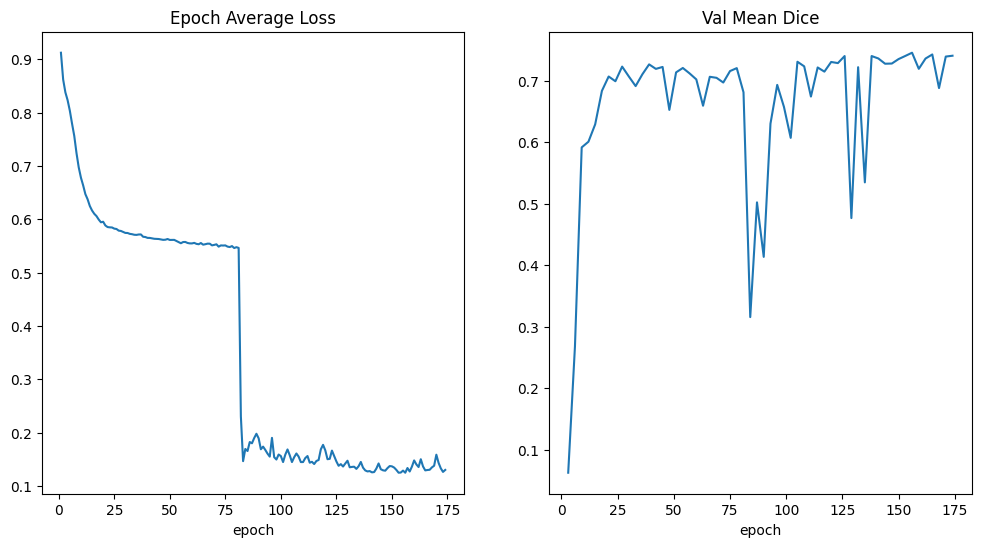

In [433]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

train completed, best_metric: 0.7454 at epoch: 156


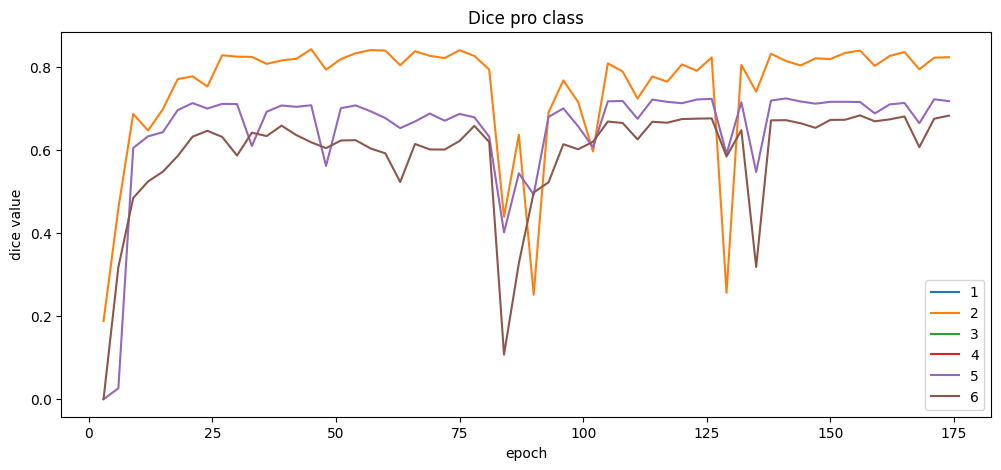

In [434]:
import matplotlib.pyplot as plt
import torch

# Assuming best_metric, best_metric_epoch, epoch_loss_values, metric_values, 
# metric_iou_values, metric_iou_pro_class_values, val_interval are defined elsewhere in your code

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

plt.figure("train", (12, 5))

# Plot "Dice per class"
plt.title("Dice pro class")
x = [val_interval * (i + 1) for i in range(len(metric_pro_class_values))]
for i in range(0,6):
    # Extract the metric values for the current class across all epochs
    y = [metric.cpu().numpy()[i] for metric in metric_pro_class_values]
    plt.plot(x, y, label=i+1)




plt.xlabel("epoch")
plt.ylabel("dice value")

plt.legend()
plt.show()


In [435]:
import numpy as np

# Assuming metric_pro_class_values is a list of tensors where each tensor contains the metric values for all classes at a particular epoch

# Initialize a list to store the maximum values for each class
max_values_per_class = []

# Iterate over each class
for i in range(6):  # Assuming you have 6 classes
    # Extract the values for the current class across all epochs and convert them to a NumPy array
    class_values = [metric.cpu().numpy()[i] for metric in metric_pro_class_values]
    
    # Find the maximum value for this class and append it to the list
    max_value = np.max(class_values)
    max_values_per_class.append(max_value)

# Print the maximum values for each class
for i, max_value in enumerate(max_values_per_class, 1):
    print(f"Class {i}: Highest Dice Value = {max_value:.4f}")


Class 1: Highest Dice Value = nan
Class 2: Highest Dice Value = 0.8418
Class 3: Highest Dice Value = nan
Class 4: Highest Dice Value = nan
Class 5: Highest Dice Value = 0.7235
Class 6: Highest Dice Value = 0.6827


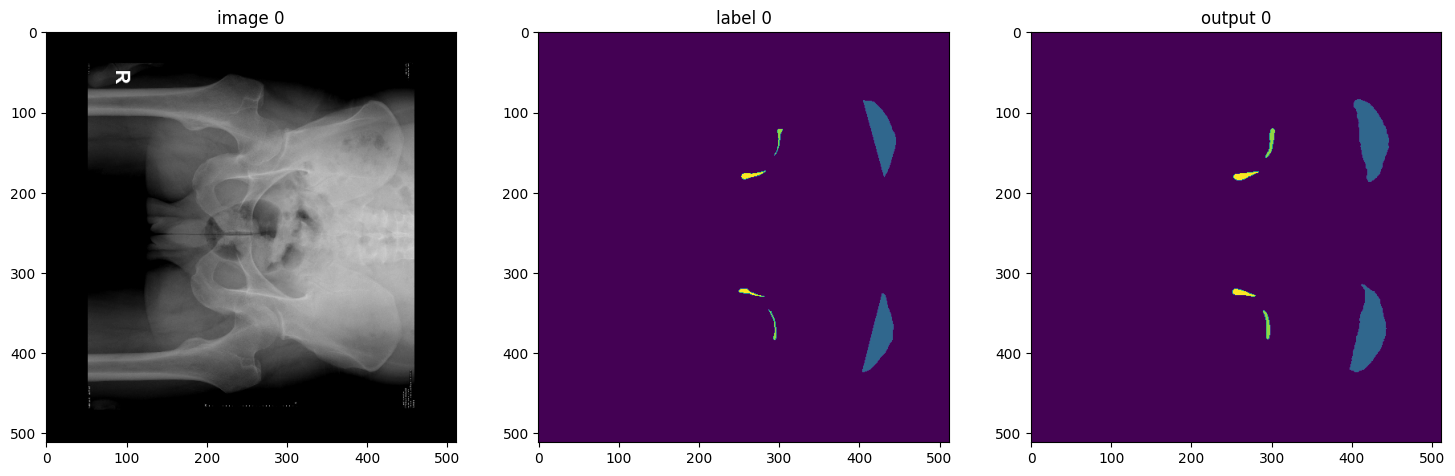

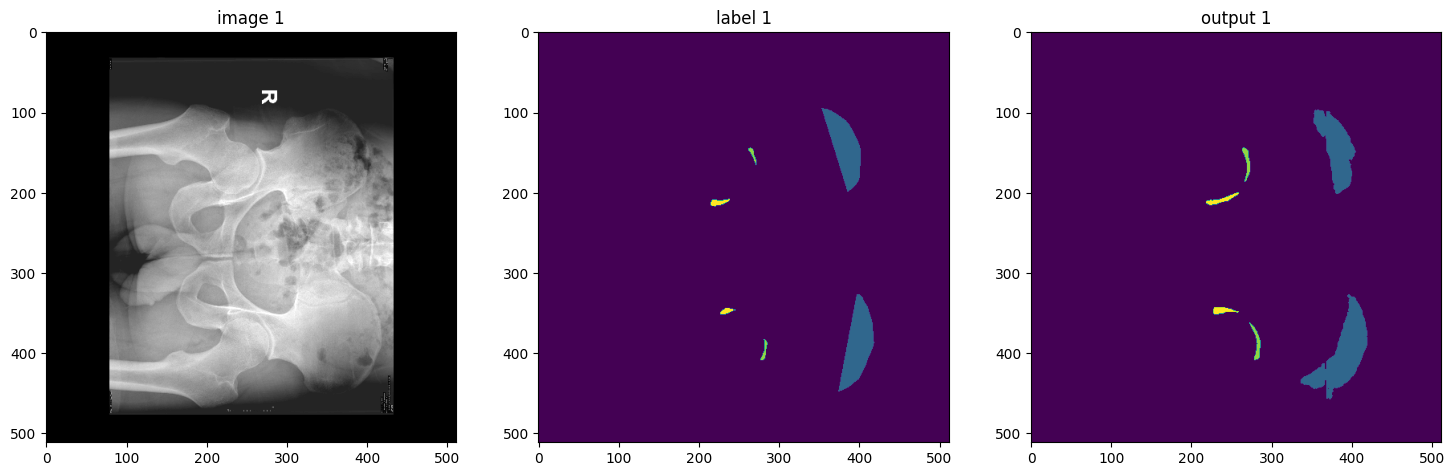

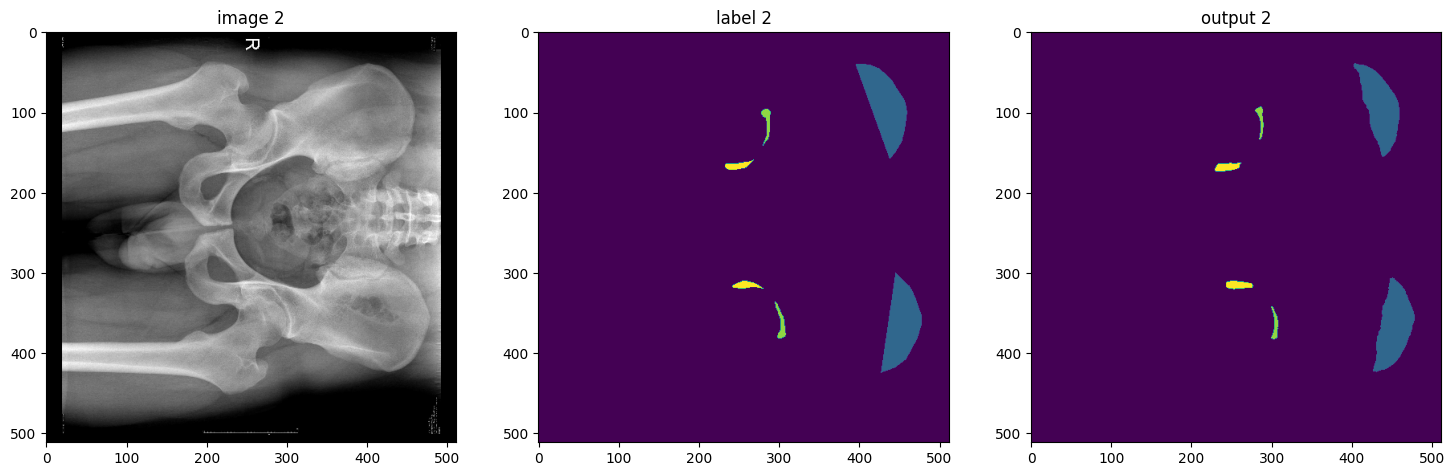

In [437]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_bone_256.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(validate_loader):
        roi_size = (480, 368)            # parameter for sliding window inference
        sw_batch_size = 4  
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :])
        plt.show()
        if i == 2:
            break

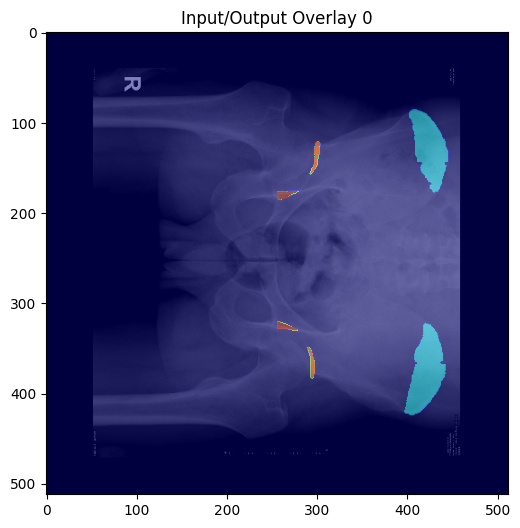

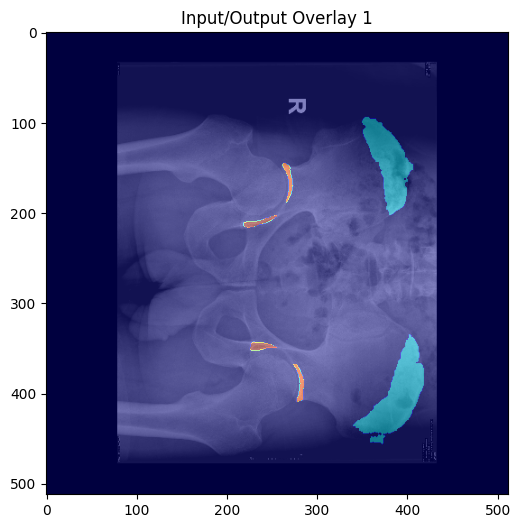

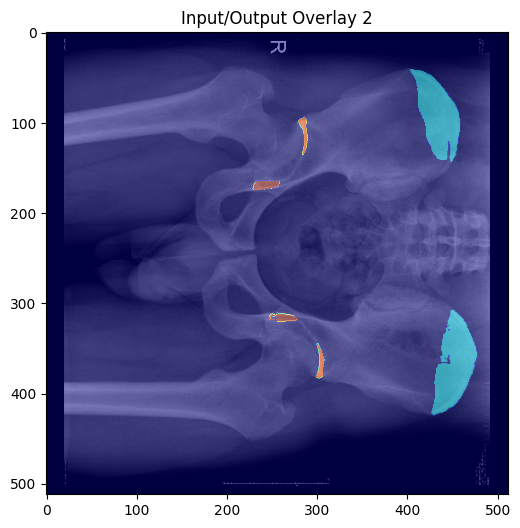

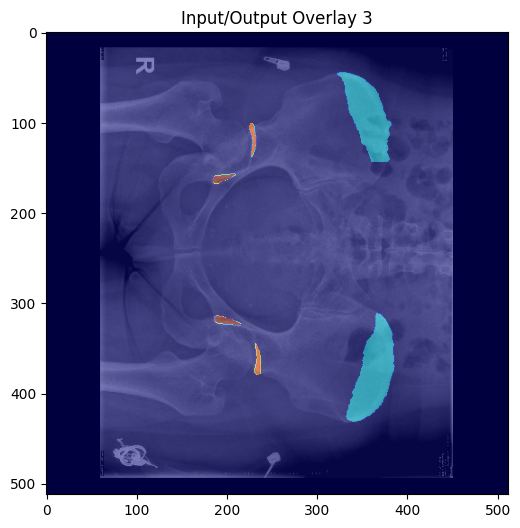

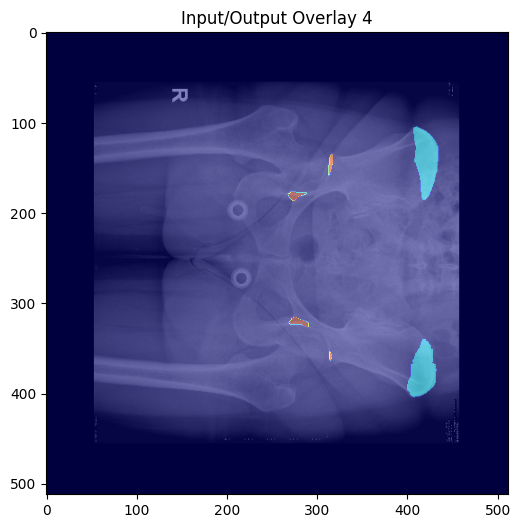

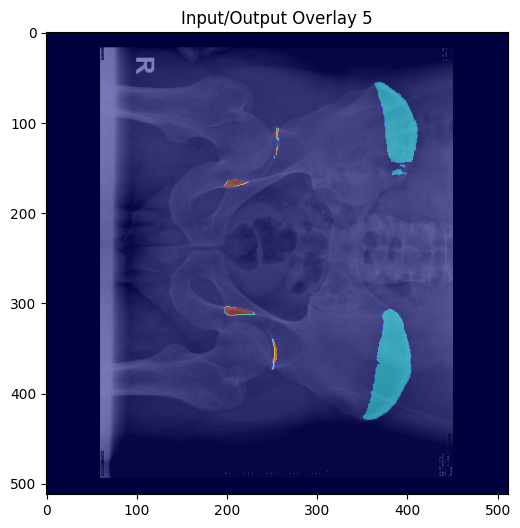

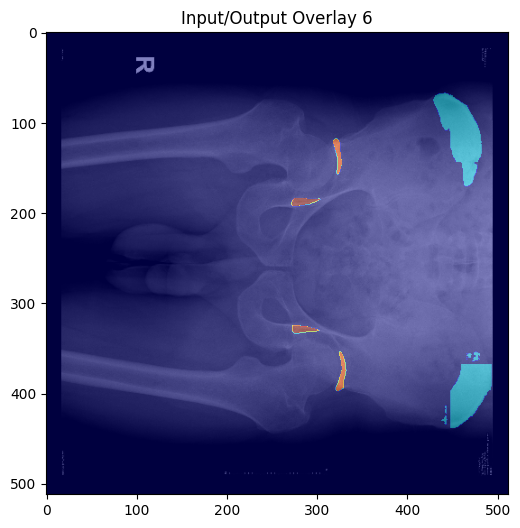

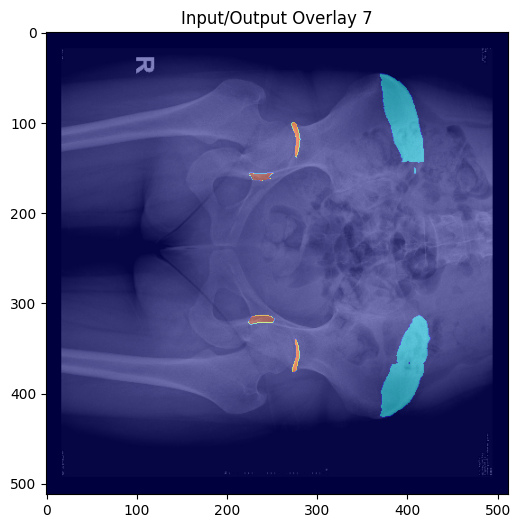

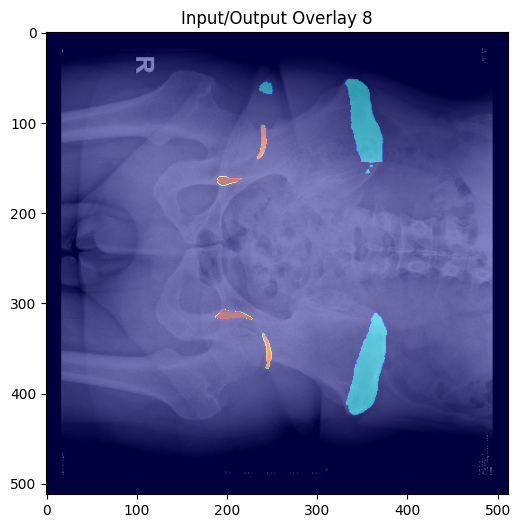

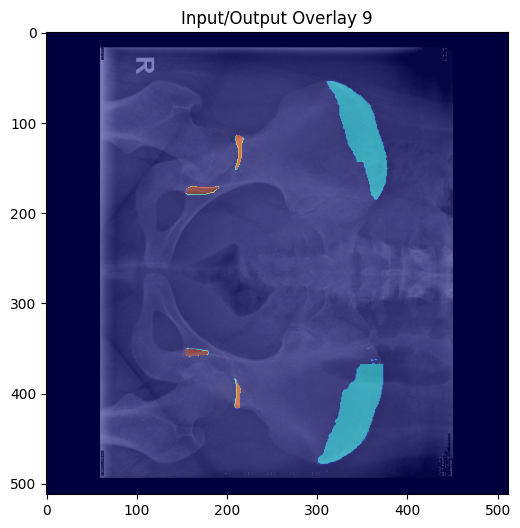

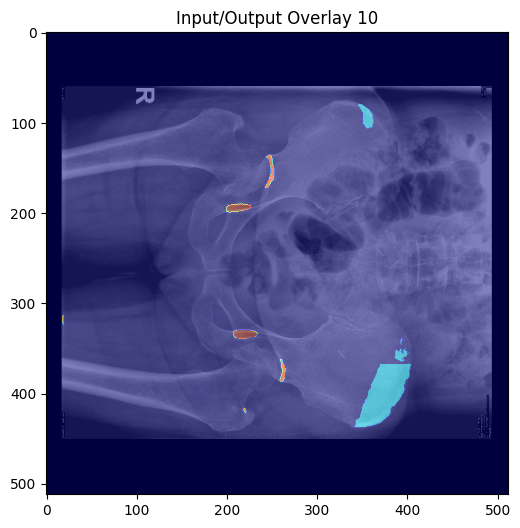

In [438]:
with torch.no_grad():
    for i, val_data in enumerate(validate_loader):
        roi_size = (368, 256)            # parameter for sliding window inference
        sw_batch_size = 4  
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        output_image = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :]

        # Plot only the overlay of input and output with adjusted figure size
        plt.figure(figsize=(6, 6))  # Adjusted to a smaller size
        plt.title(f"Input/Output Overlay {i}")
        plt.imshow(val_data["image"][0, 0, :, :], cmap="gray")
        plt.imshow(output_image, cmap='jet', alpha=0.5)  # Overlay with transparency
        plt.show()

        if i == 10:
            break